# Introduction

For this particular notebook, I will start use a very basic Multilayer Perceptron for the purposes of testing out how training, evalutation and testing will take place. As well as how the my predictions will be formated for submission.

In [151]:
import pandas as pd
import os

import torch
import csv
from PIL import Image

import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## Loading

In [13]:
image_folder = "IMAGES_1024/IMAGES_1024/"

In [35]:
train = pd.read_csv("Train.csv")
print(train.shape)
train.head()

(1326, 5)


,Image_ID,x,y,w,h
0,04FB1B33,0.481988,0.506076,0.174696,0.405671
1,B04E481E,0.617405,0.313368,0.177734,0.293113
2,32655645,0.490885,0.465856,0.165582,0.357350
3,44D4DA7C,0.472873,0.506076,0.237847,0.409722
4,4F36EF72,0.433811,0.574363,0.180773,0.397569


In [36]:
# replace image_id with image_path
for i in range(train.shape[0]):
    image_path = os.path.join(image_folder, train["Image_ID"][i] + ".JPG")
    if os.path.exists(image_path):
        train.loc[i, "Image_ID"] = image_path

In [37]:
train.head()

,Image_ID,x,y,w,h
0,IMAGES_1024/IMAGES_1024/04FB1B33.JPG,0.481988,0.506076,0.174696,0.405671
1,IMAGES_1024/IMAGES_1024/B04E481E.JPG,0.617405,0.313368,0.177734,0.293113
2,IMAGES_1024/IMAGES_1024/32655645.JPG,0.490885,0.465856,0.165582,0.357350
3,IMAGES_1024/IMAGES_1024/44D4DA7C.JPG,0.472873,0.506076,0.237847,0.409722
4,IMAGES_1024/IMAGES_1024/4F36EF72.JPG,0.433811,0.574363,0.180773,0.397569


In [43]:
train.to_csv("Train_New.csv", index=False)

In [142]:
# create a class for creating a dataset with one image and 4 labels.
# this will also apply to our model sice this task is a multi-label
# image classification task. Our model thus should output 4 distinct outputs.
class TurtleDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, transform=None):
        
        self.csv_path = pd.read_csv(csv_path)
        self.transform = transform
        
        # initialize arrays for storing image paths and labels
        self.data = []
        self.x = []
        self.y = []
        self.w = []
        self.h = []
        
        # read from csv file
        for i in range(self.csv_path.shape[0]):
                self.data.append(self.csv_path.loc[i, "Image_ID"])
                self.x.append(self.csv_path.loc[i, "x"])
                self.y.append(self.csv_path.loc[i, "y"])
                self.w.append(self.csv_path.loc[i, "w"])
                self.h.append(self.csv_path.loc[i, "h"])
                
    def  __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path = self.data[idx]
        image = Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)
        
        data_dict = {
            "image": image,
            "label": {
                "x": self.x[idx],
                "y": self.y[idx],
                "w": self.w[idx],
                "h": self.h[idx]
            }
        }
        
        return data_dict

Building custom Datasets

https://www.learnopencv.com/multi-label-image-classification-with-pytorch/

https://towardsdatascience.com/building-efficient-custom-datasets-in-pytorch-2563b946fd9f

# 

## Preprocessing and Splitting 

In [186]:
transform = transforms.Compose([
    transforms.Resize((700, 700)),
    transforms.ToTensor()
])

In [192]:
data = TurtleDataset("Train_New.csv", transform=transform)

In [210]:
# data splits
trainsize = int(len(data) * 0.7)
validationsize = int((len(data) - trainsize) / 2)
testsize = validationsize

In [211]:
traindata, remdata = torch.utils.data.random_split(data, [trainsize, len(data) - trainsize])
validationdata, testdata = torch.utils.data.random_split(remdata, [validationsize, testsize])

In [214]:
trainloader = torch.utils.data.DataLoader(traindata, batch_size=32)
validationloader = torch.utils.data.DataLoader(validationdata, batch_size=32)
testloader = torch.utils.data.DataLoader(testdata, batch_size=32)

#  

## Visualization

Visualizing both images solely and images with their bouding boxes.

In [184]:
def draw_Boundbox(image, points, color, alpha):
    # get the actual image size for scaling of the label points
    image_h, image_w = image.shape[1], image.shape[2]
    return Rectangle((points["x"]*image_w, points["y"]*image_h), 
                     points["w"]*image_w, points["h"]*image_h, ec=color,
                     fc=color, alpha=alpha)

torch.Size([3, 700, 700]) {'x': 0.4561631944444444, 'y': 0.5720486111111112, 'w': 0.2365451388888889, 'h': 0.3489583333333333}


([], [])

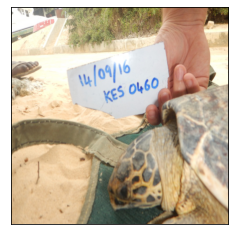

In [212]:
sample = traindata[1]

print(sample["image"].shape, sample["label"])

plt.imshow(np.transpose(sample["image"].numpy(), (1, 2, 0)))
plt.xticks([])
plt.yticks([])

([], [])

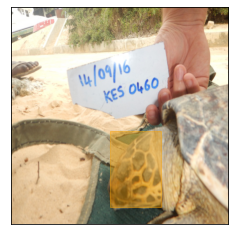

In [213]:
bound_box = draw_Boundbox(sample["image"], sample["label"], 'orange', .4)
plt.imshow(np.transpose(sample["image"].numpy(), (1, 2, 0)))
ax = plt.gca()
ax.autoscale(enable=False)
ax.add_patch(bound_box)
plt.xticks([])
plt.yticks([])

#  

## Model Design 

Model architecture and hyper parameters.

## Training and Evaluation 

## Metrics Analysis 

Visualize model accuracy in training against number of epochs.

Visualize model training and evaluation losses agains number of epochs.

## Testing 

Testing of the trained model using accuracy and also visualizing ground truths against predicted bounding box.

## Submission